In [1]:
import random
import string
import numpy as np
from deap import base, creator, tools

In [2]:
###########################
### loading the dataset ###
###########################


#load file
#And
#converting the coordinates into distances between cities
import random
import math
import tsplib95

def euclidean_2d_jitter(a, b):
    x1, y1 = a
    x2, y2 = b
    dist = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)   
    return dist * random.random() * 2

problem = tsplib95.load_problem('qa194.tsp', special=euclidean_2d_jitter)
problem.special = euclidean_2d_jitter

In [3]:
#Conveting TSP file to numpy arrays

#Comparing with original dataset from the link
random.seed(11);
np.random.seed(121);

#Quatar
INDIVIDUAL_SIZE = NUMBER_OF_CITIES = 194 + 1 
POPULATION_SIZE = 200
N_ITERATIONS = 300
N_MATINGS = 50

cities = list(problem.get_nodes())

#intialize emtpy arry with distances
distances = np.zeros((NUMBER_OF_CITIES, NUMBER_OF_CITIES))
distances[0][0] = 0 

for city in cities:
    #print(city)
    for to_city in [ i for i in cities if not i == city ]:
        #print(city)
        #print(to_city)
        distances[to_city][city] = \
            distances[city][to_city] = problem.wfunc(city,to_city)

In [4]:
#Sanity check
print(distances[1][2])
print(problem.wfunc(1,2))
#list(problem.get_nodes())
print(distances[1][1])
print(problem.wfunc(1,1))

372.0
372
0.0
0


In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()

## permutation setup for individual,
toolbox.register("indices", random.sample, range(INDIVIDUAL_SIZE), INDIVIDUAL_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)


#The important details here are that we want to minimize the fitness (shortest path). 
#The individuals need to be setup to not repeat or skip a city. Since each city must be represented, 
#we use toolbox.indices. 
#This allows our individuals to be setup with a random.sample from the values in range(INDIVIDUAL_SIZE). 



## population setup,
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=10)

In [7]:
def EVALUATE(individual):
    summation = 0
    start = individual[0]
    for i in range(1, len(individual)):
        end = individual[i]
        summation += distances[start][end]
        start = end
    return summation

toolbox.register("evaluate", EVALUATE)

In [8]:
#this runner is inpired by https://deap.readthedocs.io 

class Runner:
    
    def __init__(self, toolbox):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    def Run(self):
        population = self.toolbox.population(n=self.population_size)
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population

In [9]:
%time
a = Runner(toolbox)
a.set_parameters(POPULATION_SIZE, N_ITERATIONS, N_MATINGS)
stats, population = a.Run()

#Total runtime: 

Wall time: 0 ns


In [10]:
stats, population = a.Run()

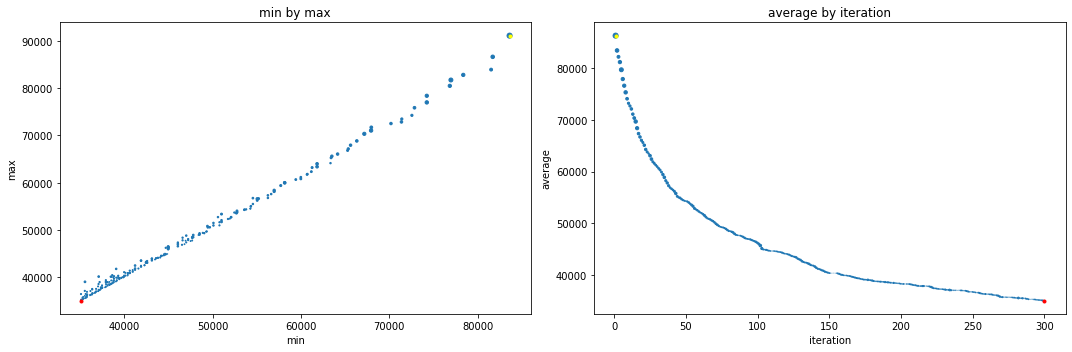

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

_ = plt.scatter([ s['min'] for s in stats ], [ s['max'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])
_ = plt.title('min by max')
_ = plt.xlabel('min')
_ = plt.ylabel('max')
_ = plt.plot(stats[0]['min'], stats[0]['max'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['min'], stats[-1]['max'], marker='.', color='red')


plt.subplot(1,2,2)

_ = plt.scatter([ s['i'] for s in stats ], [ s['mu'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])
_ = plt.title('average by iteration')
_ = plt.xlabel('iteration')
_ = plt.ylabel('average')
_ = plt.plot(stats[0]['i'], stats[0]['mu'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['i'], stats[-1]['mu'], marker='.', color='red')

plt.tight_layout()
plt.show()

In [12]:
#start at index 0 and iterate through the individual by collecting the distances between each point. 
#The sum of those distances becomes our fitness.

fitnesses = sorted([ 
    (i, toolbox.evaluate(individual)) 
    for i, individual in enumerate(population) 
], key=lambda x: x[1])

fitnesses[:5]

[(2, 35081.0), (5, 35081.0), (10, 35081.0), (13, 35081.0), (17, 35081.0)]

In [13]:
result = [x+1 for x in population[0]]
print("final restult: "+ str(result))

final restult: [122, 132, 145, 154, 151, 179, 169, 149, 75, 34, 38, 67, 101, 111, 130, 110, 120, 73, 76, 45, 36, 48, 59, 85, 107, 102, 66, 87, 126, 155, 175, 191, 176, 118, 32, 56, 89, 114, 158, 148, 159, 152, 62, 43, 20, 3, 4, 23, 52, 84, 27, 29, 10, 98, 117, 119, 137, 142, 171, 195, 188, 177, 170, 167, 160, 163, 193, 178, 182, 194, 190, 153, 28, 13, 11, 16, 22, 80, 82, 99, 95, 91, 60, 12, 144, 172, 186, 156, 138, 147, 121, 104, 97, 71, 42, 39, 41, 33, 58, 46, 51, 54, 53, 57, 68, 65, 78, 61, 30, 25, 88, 64, 133, 141, 127, 96, 106, 108, 109, 162, 157, 143, 161, 134, 26, 15, 44, 47, 31, 49, 90, 63, 105, 140, 181, 189, 173, 164, 128, 139, 165, 174, 192, 185, 187, 184, 131, 115, 112, 100, 86, 21, 2, 7, 9, 5, 72, 77, 18, 14, 8, 6, 50, 69, 40, 35, 74, 79, 93, 70, 55, 113, 116, 81, 24, 37, 83, 135, 180, 183, 129, 125, 123, 103, 94, 92, 124, 136, 168, 166, 146, 150, 1, 17, 19]
